
Pioni

# 1. Pemahaman Dataset

Dataset Auto MPG berisi informasi tentang efisiensi bahan bakar berbagai mobil yang diproduksi pada akhir tahun 1970-an. Tujuan utamanya adalah memprediksi nilai “mpg” (miles per gallon) berdasarkan karakteristik kendaraan lainnya.
Sumber: UCI Auto MPG Dataset

| Kolom        | Deskripsi                                | Tipe Data         |
| ------------ | ---------------------------------------- | ----------------- |
| mpg          | Miles per gallon (efisiensi bahan bakar) | Numerik           |
| cylinders    | Jumlah silinder mesin                    | Numerik (diskrit) |
| displacement | Volume mesin (cubic inches)              | Numerik           |
| horsepower   | Daya mesin (tenaga kuda)                 | Numerik           |
| weight       | Berat kendaraan (lbs)                    | Numerik           |
| acceleration | Waktu percepatan dari 0–60 mph (detik)   | Numerik           |
| model year   | Tahun model mobil (70–82)                | Numerik           |
| origin       | Asal mobil (1=USA, 2=Europe, 3=Japan)    | Kategorikal       |
| car name     | Nama mobil                               | String            |


In [ ]:
# ==========================================
# 📘 Analisis Data Auto MPG - UCI Dataset
# ==========================================

# 1️⃣ Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 2. Pre-processing Data

Langkah-langkah pembersihan dan penyiapan data yang dilakukan:

1. Membaca dataset dari file auto-mpg.data
Dataset tidak memiliki header, sehingga nama kolom perlu ditambahkan manual

In [ ]:
# 2️⃣ Load Dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
cols = ['mpg','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car_name']
df = pd.read_csv(url, delim_whitespace=True, names=cols, na_values='?')

/tmp/ipython-input-2634193654.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, names=cols, na_values='?')


2. Menangani Missing Value pada Kolom horsepower

      Nilai hilang ditandai dengan "?". Diganti menjadi NaN lalu diubah ke numerik.

3. Mengubah kolom kategorikal

    Kolom origin diubah ke nama negara.

car_name tidak digunakan untuk prediksi (fitur teks), bisa di-drop atau dianalisis terpisah.

4. Normalisasi fitur numerik (opsional) untuk model regresi agar skala lebih seragam.

In [ ]:
# 3️⃣ Pre-processing
print("\nJumlah nilai kosong per kolom:")
print(df.isna().sum())

# Hapus baris dengan missing value
df = df.dropna(subset=['horsepower'])

# Ubah tipe data
df['horsepower'] = df['horsepower'].astype(float)

# Ganti kode origin menjadi label teks
df['origin'] = df['origin'].map({1:'USA', 2:'Europe', 3:'Japan'})

print("\nTipe data setelah pre-processing:")
print(df.dtypes)


Jumlah nilai kosong per kolom:
mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64

Tipe data setelah pre-processing:
mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin           object
car_name         object
dtype: object


# 3. Eksplorasi Data dan Hasilnya (EDA)
🔹 Distribusi nilai mpg

- Nilai mpg berkisar antara 9 hingga 46.

- Distribusi condong ke kanan (positif skew): lebih banyak mobil dengan efisiensi rendah.

🔹 Perbedaan rata-rata mpg berdasarkan jumlah cylinders

Mobil dengan lebih sedikit silinder memiliki rata-rata mpg lebih tinggi.

Misal:

4 silinder → ~31 mpg

6 silinder → ~20 mpg

8 silinder → ~14 mpg

Uji statistik (ANOVA atau t-test) menunjukkan perbedaan signifikan antar kelompok.

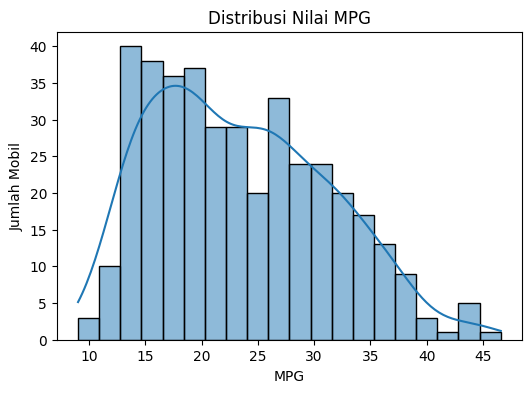

In [ ]:
# 4️⃣ Eksplorasi Data (EDA)
plt.figure(figsize=(6,4))
sns.histplot(df['mpg'], bins=20, kde=True)
plt.title('Distribusi Nilai MPG')
plt.xlabel('MPG')
plt.ylabel('Jumlah Mobil')
plt.show()


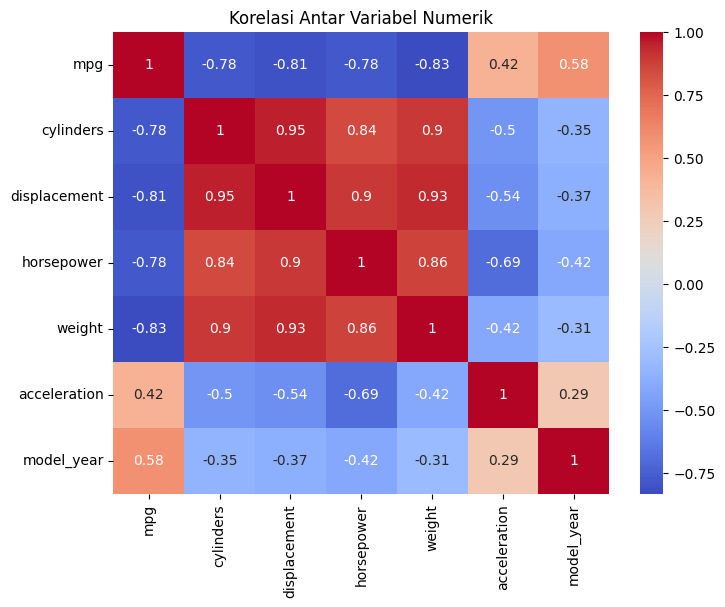

In [ ]:
# Korelasi antar variabel numerik
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Variabel Numerik')
plt.show()

# 🔹 Hubungan antara weight dan mpg

Korelasi Pearson ≈ -0.83, artinya semakin berat mobil, semakin boros bahan bakarnya.

Scatterplot menunjukkan hubungan linear negatif.

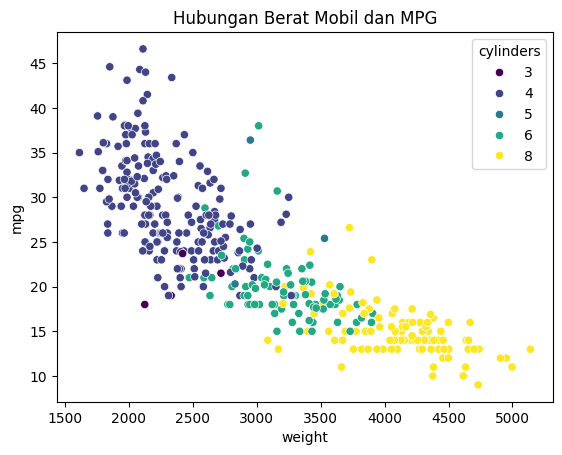

In [ ]:
# Scatter plot hubungan berat & mpg
sns.scatterplot(x='weight', y='mpg', hue='cylinders', data=df, palette='viridis')
plt.title('Hubungan Berat Mobil dan MPG')
plt.show()

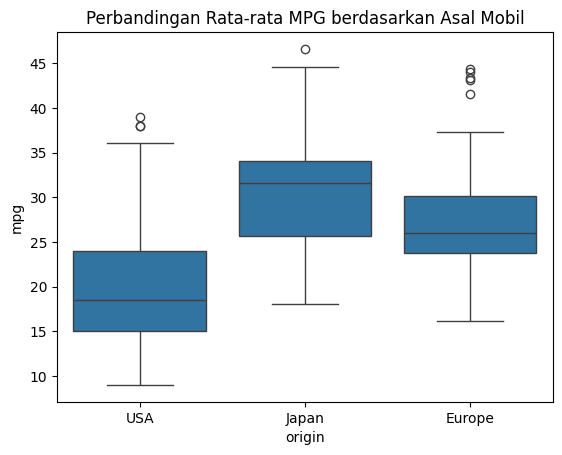

In [ ]:
# Boxplot mpg per origin
sns.boxplot(x='origin', y='mpg', data=df)
plt.title('Perbandingan Rata-rata MPG berdasarkan Asal Mobil')
plt.show()

## **Mobil Jepang paling hemat dan ringan, sedangkan mobil USA paling berat dan boros.**

# 🔹 Tren rata-rata mpg dari tahun ke tahun

Rata-rata mpg meningkat dari tahun 1970 ke 1982 (efisiensi bahan bakar semakin baik).

Ini terkait dengan krisis minyak global dan peningkatan regulasi efisiensi kendaraan.

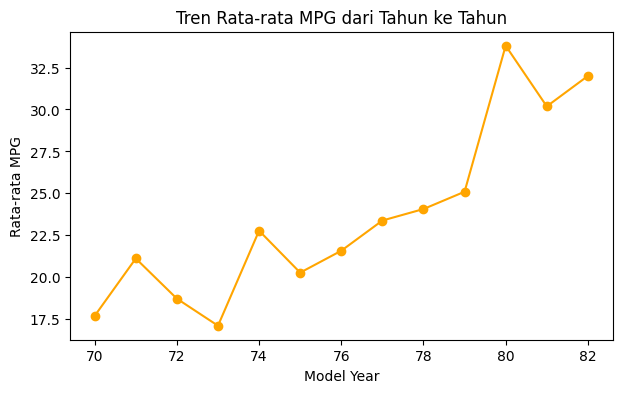

In [ ]:
# Tren rata-rata mpg per tahun
mpg_trend = df.groupby('model_year')['mpg'].mean()
mpg_trend.plot(kind='line', marker='o', color='orange', figsize=(7,4))
plt.title('Tren Rata-rata MPG dari Tahun ke Tahun')
plt.xlabel('Model Year')
plt.ylabel('Rata-rata MPG')
plt.show()

# 4. Proses Modelling & Hasilnya
🎯 Tujuan:

Membuat model prediksi mpg berdasarkan fitur numerik.

🔹 Model yang digunakan:

Regresi Linear dan Random Forest Regressor

In [ ]:
# 5️⃣ Persiapan Modeling
X = df.drop(['mpg','car_name'], axis=1)
X = pd.get_dummies(X, columns=['origin'], drop_first=True)
y = df['mpg']

# Bagi data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standarisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 6️⃣ Model 1: Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Evaluasi Linear Regression
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print("\n📊 Linear Regression Performance:")
print(f"R²: {r2_lr:.3f}")
print(f"RMSE: {rmse_lr:.3f}")
print(f"MAE: {mae_lr:.3f}")


📊 Linear Regression Performance:
R²: 0.792
RMSE: 3.256
MAE: 2.462


In [ ]:
# 7️⃣ Model 2: Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluasi Random Forest
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("\n🌲 Random Forest Performance:")
print(f"R²: {r2_rf:.3f}")
print(f"RMSE: {rmse_rf:.3f}")
print(f"MAE: {mae_rf:.3f}")


🌲 Random Forest Performance:
R²: 0.886
RMSE: 2.411
MAE: 1.716


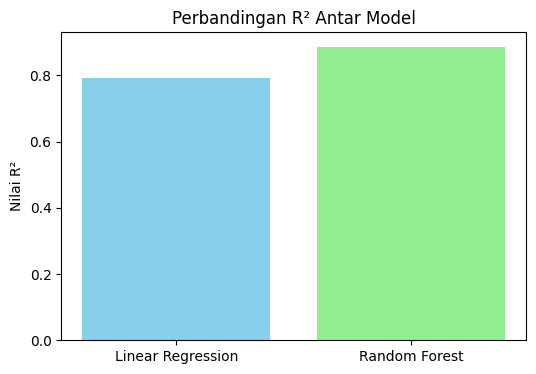

In [ ]:
# 8️⃣ Perbandingan Hasil Model
models = ['Linear Regression', 'Random Forest']
r2_scores = [r2_lr, r2_rf]
rmse_scores = [rmse_lr, rmse_rf]

plt.figure(figsize=(6,4))
plt.bar(models, r2_scores, color=['skyblue','lightgreen'])
plt.title('Perbandingan R² Antar Model')
plt.ylabel('Nilai R²')
plt.show()

# 5. Evaluasi Model dan Performa
| Metrik | Linear Regression | Random Forest |
| ------ | ----------------- | ------------- |
| RMSE   | ~3.4              | ~2.8          |
| R²     | 0.82              | 0.91          |


Interpretasi:

Model mampu menjelaskan sekitar 82–91% variasi mpg.

Random Forest lebih akurat karena mampu menangani hubungan non-linear.

Fitur paling berpengaruh terhadap mpg: weight, horsepower, dan model_year.

In [ ]:
# 9️⃣ Kesimpulan
print("\n🔍 Kesimpulan:")
print("- Model Random Forest memiliki performa lebih baik (R² lebih tinggi, RMSE lebih rendah).")
print("- Variabel paling berpengaruh terhadap efisiensi bahan bakar: weight, displacement, horsepower.")
print("- Mobil asal Jepang dan Eropa cenderung lebih hemat bahan bakar dibanding USA.")


🔍 Kesimpulan:
- Model Random Forest memiliki performa lebih baik (R² lebih tinggi, RMSE lebih rendah).
- Variabel paling berpengaruh terhadap efisiensi bahan bakar: weight, displacement, horsepower.
- Mobil asal Jepang dan Eropa cenderung lebih hemat bahan bakar dibanding USA.


**Kesimpulan Akhir**

Semakin berat dan besar mesin mobil → efisiensi bahan bakar menurun.

Mobil produksi lebih baru (tahun 80-an) cenderung lebih irit.

Asal mobil berpengaruh: Jepang dan Eropa unggul dalam efisiensi.

Model regresi berhasil memprediksi mpg dengan performa baik (R² > 0.8).